In [3]:
from ncps.wirings import AutoNCP
from ncps.torch import LTC

In [4]:
help(LTC)

Help on class LTC in module ncps.torch.ltc:

class LTC(torch.nn.modules.module.Module)
 |  LTC(input_size: int, units, return_sequences: bool = True, batch_first: bool = True, mixed_memory: bool = False, input_mapping='affine', output_mapping='affine', ode_unfolds=6, epsilon=1e-08, implicit_param_constraints=True)
 |  
 |  Method resolution order:
 |      LTC
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_size: int, units, return_sequences: bool = True, batch_first: bool = True, mixed_memory: bool = False, input_mapping='affine', output_mapping='affine', ode_unfolds=6, epsilon=1e-08, implicit_param_constraints=True)
 |      Applies a `Liquid time-constant (LTC) <https://ojs.aaai.org/index.php/AAAI/article/view/16936>`_ RNN to an input sequence.
 |      
 |      Examples::
 |      
 |           >>> from ncps.torch import LTC
 |           >>>
 |           >>> rnn = LTC(20,50)
 |           >>> x = torch.randn(2, 

In [5]:
import torch
rnn = LTC(20,50)
x = torch.randn(2, 3, 20) # (batch, time, features)
h0 = torch.ones(2,50) # (batch, units)
output, hn = rnn(x,h0)

In [ ]:
print(h)

In [7]:
output.shape

torch.Size([2, 3, 50])

torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size([2, 3, 50])
torch.Size(

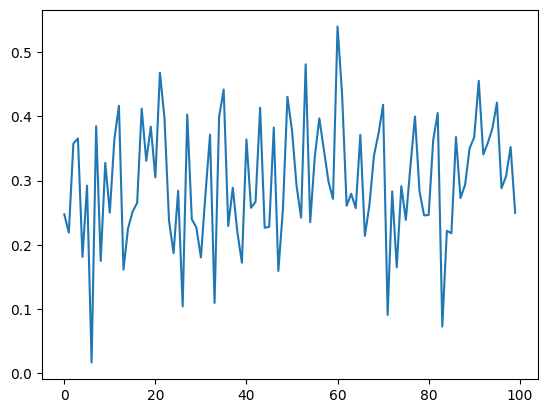

In [9]:
outputs = []
for i in range(100):
    x = torch.randn(2, 3, 20) # (batch, time, features)
    h0 = torch.ones(2,50) # (batch, units)
    output, hn = rnn(x,h0)
    print(output.shape)
    outputs.append(output[0,0,0].item())

import matplotlib.pyplot as plt

plt.plot(outputs)


In [10]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np


class DelaySampleToMatchEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, reward, n_stimuli=5, delay_length=1):
        super(DelaySampleToMatchEnv, self).__init__()

        self.reward = reward

        # Number of different stimuli (excluding the delay)
        self.n_stimuli = n_stimuli

        # Length of delay between stimuli
        self.delay_length = delay_length

        # Action space and observation space
        # Stimuli are represented as integers from 0 to n_stimuli (0 is the delay)
        self.action_space = spaces.Discrete(n_stimuli + 1)
        self.observation_space = spaces.Discrete(n_stimuli + 1)

        # Initialize the sequence and current step
        self.sequence = []
        self.current_step = 0
        self.first_stimulus = None

    def _generate_sequence(self):
        # Randomly select n stimuli (1 to n_stimuli, excluding 0 which is the delay)
        stimuli = np.random.choice(
            range(1, self.n_stimuli + 1), self.n_stimuli, replace=False)

        self.first_stimulus = stimuli[0]
        # Create the sequence: stimulus1-delay-stimulus2-delay-...-stimulusN-stimulus1
        sequence = [0]
        for stimulus in stimuli:
            sequence.append(stimulus)
            sequence.extend([0] * self.delay_length)  # 0 represents the delay
        sequence.append(stimuli[0])
        # print(sequencep)
        return sequence

    def reset(self):
        # Generate a new sequence for the episode
        self.sequence = self._generate_sequence()
        self.current_step = 0
        # Return the first stimulus
        return self.sequence[self.current_step]

    def step(self, action):
        reward = 0
        done = False

        # If the action is non-zero and the current stimulus is a delay, give a reward of -1
        if action != 0 and self.sequence[self.current_step] == 0:
            reward = -1

        if self.current_step < len(self.sequence) - 1:
            if action != 0:
                # print('boom')
                reward = -1
            else:
                reward = 0

        # If the current step is the last one, check if the action matches the first stimulus
        if self.current_step == len(self.sequence) - 1:
            done = True
            # print(self.sequence, self.sequence[self.current_step])
            if action == self.first_stimulus:
                reward = self.reward
            else:
                reward = -1

        # Advance to the next step
        self.current_step += 1

        # Check if the episode is done
        done = self.current_step >= len(self.sequence)

        # Get the next observation
        if not done:
            observation = self.sequence[self.current_step]
        else:
            observation = 0

        return observation, reward, done, {}

    def render(self, mode='human'):
        if self.current_step < len(self.sequence):
            print(
                f"Step {self.current_step}: Stimulus {self.sequence[self.current_step]}")
        else:
            print("Episode finished.")


'''
# Example usage
env = DelaySampleToMatchEnv(n_stimuli=15, delay_length=1)
observation = env.reset()
done = False

while not done:
    print("Current Observation:", observation)
    action = env.action_space.sample()  # Random action (for demonstration purposes)
    observation, reward, done, info = env.step(action)
    env.render()
    print(f"Action: {action}, Reward: {reward}")

env.close()
'''

'\n# Example usage\nenv = DelaySampleToMatchEnv(n_stimuli=15, delay_length=1)\nobservation = env.reset()\ndone = False\n\nwhile not done:\n    print("Current Observation:", observation)\n    action = env.action_space.sample()  # Random action (for demonstration purposes)\n    observation, reward, done, info = env.step(action)\n    env.render()\n    print(f"Action: {action}, Reward: {reward}")\n\nenv.close()\n'